# *t*-SNE Plot for LOINC Embeddings
**Lorenzo Rossi** (lrossi@coh.org, lorenzo.rossi@gmail.com) 

This notebook reproducees the *t*-SNE plot (Figure 3, page 4) in the [KDD 2019 DSHealth Workshop](https://dshealthkdd.github.io/dshealth-2019/) paper "Evaluation of Embeddings of Laboratory Test Codes for Patients at a Cancer Center": [arxiv.org/abs/1907.09600](https://arxiv.org/abs/1907.09600). The code can be used as a starting point for furtrher in depth exploration of the embeddings.

The embeddings have been trained via Word2Vec skip-gram with EHR data from the [City of Hope National Medical Center](https://www.cityofhope.org/homepage). See paper for details on the training.

## Files Needed to Run the Notebook
The word2vec embeddings for the LOINCs are provided as well as other files, but you will need to downlload the official LOINC CSV file from [loing.org](https://loinc.org). That CSV file is necessary to provide a taxonomy of the LOINC code and hence the classes showed in different colors in the scatter plot.

### How to download the official Loinc Table CSV file
* Create an account on LOINC.org (it's free) and log in
* Click on 'Downloads' (menu at the top of the page)
* Click on 'LOINC Table'
* Click on 'LOINC Table File (CSV)'
* Review and check the Copyright and Terms of Use note
* Click on 'Download': a zip archive will be downloaded on your machine
* Extraxct the Loinc.csv from the zip archive

### Versions
```
scikit-learn 0.19.2
pandas 0.23.4
gensim 3.7.3
seaborn 0.9.0

```

## Citation
If you use the material in your work, please cite our paper. __BibTeX entry:__

```
@inproceedings{larossi2019evaluation,
  title={Evaluation of Embeddings of Laboratory Test Codes for Patients at a Cancer Center},
  author={Rossi, Lorenzo A and Shawber, Chad and Munu, Janet and Zachariah, Finly},
  booktitle={KDD Workshop on Applied Data Science for Healthcare (DSHealth)},
  year={2019}
}
```

In [1]:
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.manifold import TSNE
from gensim.models import Word2Vec, KeyedVectors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib.pyplot as plt

def loinc_class_mapping(ct, map_to_other):
    try:
        return map_to_other[ct]
    except (TypeError, KeyError) as e:
        return ct

def simplify(element, select_list):
    if element in select_list:
        return element
    else:
        return 'Other'

%matplotlib

Using matplotlib backend: TkAgg


In [2]:
# Parameter setting, file and folder names

hc_trained_infolder = 'Data/'
vec_folder = 'Data/'
doc_folder = 'Data/'
in_fold = 'Data/'

embedding_fname = 'loinc_s200_w5_c5_sg_wv.txt'
cnt_fname = 'loinc_counts.csv'
lab_cat_fname = 'coh_top_500_lab_cats_cs.csv'
loinc_official_fname = 'Loinc.csv'

# parameters
rnd_seed = 201905
n_max_codes = 500
min_class_size = 12

#Abbreviations for classes of LOINCs [loing.org]
loinc_class_dict = {'ABXBACT':'Antibiotic susceptibilities', 'PULM':'Pulmonary', 'COAG':'Coagulation study', 
                    'DRUG/TOX':'Drug levels & Toxicology', 'HEM/BC': 'Hematology/Cell counts', 'CHEM':'Chemistry',
                    'UA':'Urinalysis', 'MICRO':'Microbiology', 'SERO':'Serology', 'SPEC':'Specimen characteristics',
                    'CELLMARK': 'Cell Markers', 'OTHER': 'Other'}

In [3]:
# File loading

# Word2Vec embeddings for LOINCs
cd_embs = KeyedVectors.load_word2vec_format(vec_folder+embedding_fname, binary=False)
print('loaded word vectors from', embedding_fname)

# COH past LOINC frequencies
cd_counts = pd.read_csv(doc_folder+cnt_fname, header=0, squeeze=True, index_col=0)

# Manual categorization of lab tests (used)
lab_cats = pd.read_csv(in_fold+lab_cat_fname, header=0)

# Official loinc.org table
loinc_offic = pd.read_csv(in_fold+loinc_official_fname, header=0, low_memory=False)

loaded word vectors from loinc_s200_w5_c5_sg_wv.txt


In [4]:
# t-SNE computations

print('Restrict to', n_max_codes, 'most frequent codes')
top_n_codes = cd_counts[:n_max_codes].index.tolist()
##top_n_code_names = [cd_dict[cd] for cd in top_n_codes]


tsne = TSNE(n_components=2, perplexity=20, learning_rate=40, n_iter=5000, random_state=rnd_seed)
X_tsne = tsne.fit_transform(cd_embs[top_n_codes])
print('t-SNE completed')

Restrict to 500 most frequent codes
t-SNE completed


In [5]:
# Merging CoH internal LOINC data with loinc.org Table
lab_cats = lab_cats.merge(loinc_offic, how='left', left_on='Loinc', right_on='LOINC_NUM')# -loinc_offic.columns
coh_lab_official = lab_cats[['LOINC_NUM', 'Lab', 'SHORTNAME', 'LONG_COMMON_NAME', 'COMPONENT', 'Category',
                             'CLASS', 'SYSTEM', 'CLASSTYPE', 'PROPERTY','EXAMPLE_UNITS', 'RELATEDNAMES2']]
coh_lab_official.rename({'Lab': 'COH_NAME', 'Category': 'MANUAL_CATEGORY'}, axis='columns', inplace=True)
coh_lab_official['COUNTS'] = cd_counts.values[:len(coh_lab_official)]

In [6]:
# LOINC class simplification

class_counts = coh_lab_official.groupby('CLASS').size().sort_values(ascending=False)
map_to_other = pd.Series(dict([(item, 'OTHER') for item in class_counts[class_counts<min_class_size].index]))

simplified_classes = coh_lab_official['CLASS'].apply(lambda x: loinc_class_mapping(x, map_to_other), 1)
simplified_classes = simplified_classes.map(loinc_class_dict)

# Manual categorization simplification
select_panels = ['Complete Blood Count']#, 'Metabolic Panel']
panel = coh_lab_official.MANUAL_CATEGORY.apply(lambda x: simplify(x, select_panels))
panel.name = 'PANEL'

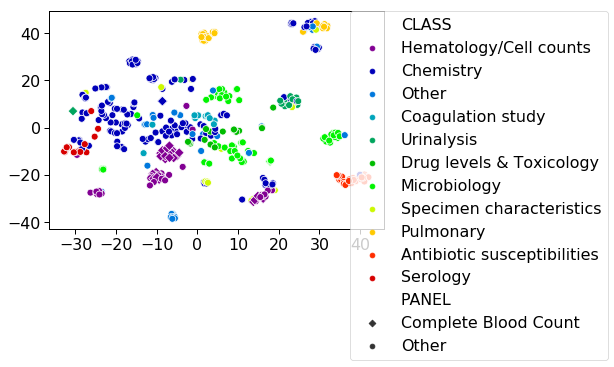

In [7]:
# t-SNE Plot

palet = 'nipy_spectral'
#
filled_markers = ('o', 'v', '^', '<', '>', 's', 'p', '*', 'X',  'P', 'H', 'D', 'd')
plt.figure()
with sns.plotting_context('paper', font_scale=1.8):
    sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=simplified_classes, style=panel, markers=['D', 'o'], 
                    s=48, palette=palet)
    plt.legend(bbox_to_anchor=(.9, 1), loc=2, borderaxespad=0.)